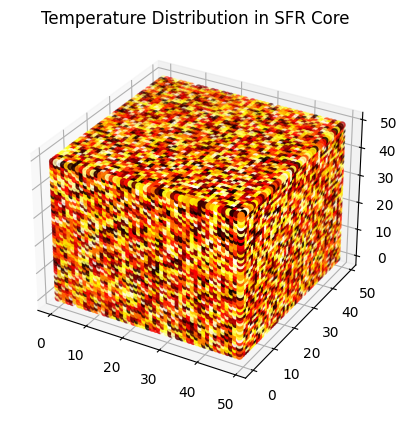

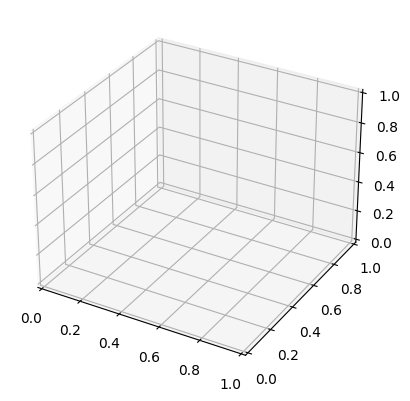

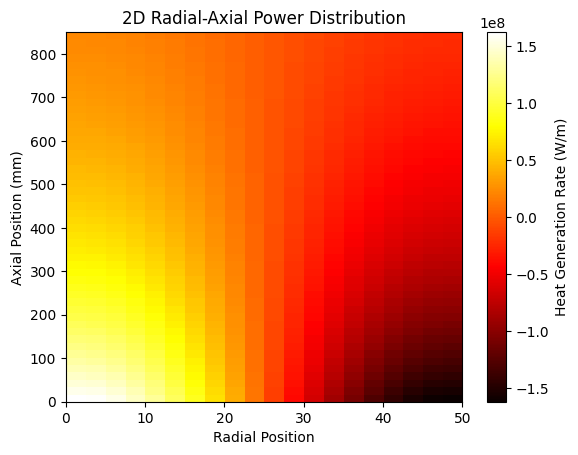

Neutrons absorbed: 937
Neutrons escaped: 63


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Global parameters for the reactor core
core_size = 50
core_radius = 50  # Number of radial nodes
core_height = 20  # Number of axial nodes
D = 0.2  # Diffusion coefficient
S = 1.0  # Neutron source strength
rho_Na = 830  # Density of sodium (kg/m^3)
Cp = 1268  # Specific heat capacity (J/kg.K)

# Initial neutron flux distribution
flux = np.random.rand(core_size, core_size, core_size)

# Function to update neutron flux based on diffusion equation
def update_flux(flux, D, S):
    flux_new = flux.copy()
    for i in range(1, core_size - 1):
        for j in range(1, core_size - 1):
            for k in range(1, core_size - 1):
                flux_new[i, j, k] = (
                    flux[i, j, k] +
                    D * (flux[i+1, j, k] + flux[i-1, j, k] + flux[i, j+1, k] + flux[i, j-1, k] + flux[i, j, k+1] + flux[i, j, k-1] - 6 * flux[i, j, k]) +
                    S
                )
    return flux_new

# Update flux over time
def simulate_neutron_flux(steps=100):
    global flux
    for _ in range(steps):
        flux = update_flux(flux, D, S)

simulate_neutron_flux(steps=10)

# Thermal properties
thermal_diffusivity = 1e-4  # Simplified thermal diffusivity

# Initial temperature distribution
temperature = np.random.rand(core_size, core_size, core_size) * 300 + 600  # Starting at 600K

# Function to update temperature distribution
def update_temperature(temperature, flux):
    temperature_new = temperature.copy()
    for i in range(1, core_size - 1):
        for j in range(1, core_size - 1):
            for k in range(1, core_size - 1):
                temperature_new[i, j, k] = (
                    temperature[i, j, k] +
                    thermal_diffusivity * (
                        temperature[i+1, j, k] + temperature[i-1, j, k] +
                        temperature[i, j+1, k] + temperature[i, j-1, k] +
                        temperature[i, j, k+1] + temperature[i, j, k-1] - 6 * temperature[i, j, k]
                    ) +
                    flux[i, j, k] * 1e-2  # Simplified heat generation from neutron flux
                )
    return temperature_new

# Update temperature over time
def simulate_temperature(steps=100):
    global temperature
    for _ in range(steps):
        temperature = update_temperature(temperature, flux)

simulate_temperature(steps=10)

def plot_temperature():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.indices((core_size, core_size, core_size))
    ax.scatter(x, y, z, c=temperature.ravel(), cmap='hot', marker='o')
    ax.set_title('Temperature Distribution in SFR Core')
    plt.show()

plot_temperature()

# Real-time animation of temperature distribution
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.indices((core_size, core_size, core_size))

def animate(i):
    global temperature
    temperature = update_temperature(temperature, flux)
    ax.clear()
    ax.scatter(x, y, z, c=temperature.ravel(), cmap='hot', marker='o')
    ax.set_title(f'Temperature Distribution in SFR Core - Step {i}')
    return ax,

ani = FuncAnimation(fig, animate, frames=100, interval=200, blit=False)
plt.show()

# Define radial positions
r = np.linspace(0, core_radius, core_radius)
z = np.linspace(0, 850, core_height)

# Radial power distribution based on peaking factor Kr
Kr = 1.35  # Radial peaking factor
Kz = 1.2  # Axial peaking factor
q_max = 1e8  # Max linear heat generation rate (W/m)

# Initialize the 2D power distribution array (radial x axial)
q_rz = np.zeros((core_radius, core_height))

for i in range(core_radius):
    for j in range(core_height):
        radial_factor = np.exp(-r[i] / (core_radius / 2))  # Simplified radial distribution
        axial_factor = np.cos(np.pi * z[j] / z[-1])  # Axial distribution
        q_rz[i, j] = q_max * Kr * radial_factor * Kz * axial_factor

# Plot the 2D power distribution
plt.imshow(q_rz, cmap='hot', extent=[0, core_radius, 0, 850], origin='lower', aspect='auto')
plt.colorbar(label='Heat Generation Rate (W/m)')
plt.title('2D Radial-Axial Power Distribution')
plt.xlabel('Radial Position')
plt.ylabel('Axial Position (mm)')
plt.show()

# Control rod mechanism to adjust the power based on temperature limits
def adjust_power(q_rz, T_rz, T_max=2700, cladding_limit=700):
    for i in range(core_radius):
        for j in range(core_height):
            if T_rz[i, j] > T_max:
                q_rz[i, j] *= 0.95  # Reduce power if temperature exceeds limit
            elif T_rz[i, j] > cladding_limit:
                q_rz[i, j] *= 0.98  # Reduce power moderately if cladding limit is exceeded
    return q_rz

# 2D Temperature update function
def update_temperature_2d(T_rz, q_rz):
    T_new = T_rz.copy()
    for i in range(1, core_radius - 1):
        for j in range(1, core_height - 1):
            T_new[i, j] = (
                T_rz[i, j] + (q_rz[i, j] / (rho_Na * Cp)) *
                (T_rz[i+1, j] + T_rz[i-1, j] + T_rz[i, j+1] + T_rz[i, j-1] - 4 * T_rz[i, j])
            )
    return T_new

# Simulation loop with control mechanism
def simulate_reactor(steps=100):
    global q_rz  # Declare q_rz as global to ensure it's accessible inside the function
    T_rz = np.random.rand(core_radius, core_height) * 300 + 600  # Initial temperatures
    for step in range(steps):
        T_rz = update_temperature_2d(T_rz, q_rz)
        q_rz = adjust_power(q_rz, T_rz)
        # Update visualization or log results here...

simulate_reactor(steps=50)

import random

# Parameters for the Monte Carlo neutron transport
num_neutrons = 1000  # Number of neutrons to simulate
mean_free_path = 2.0  # Mean free path (simplified)
absorbed_neutrons = 0
escaped_neutrons = 0

def simulate_neutron_path():
    position = np.array([core_radius // 2, core_height // 2], dtype=float)  # Start at core center, ensuring position is float type
    for step in range(100):  # Simulate up to 100 interactions
        # Randomly choose a direction
        angle = random.uniform(0, 2 * np.pi)
        displacement = mean_free_path * np.array([np.cos(angle), np.sin(angle)])
        position += displacement

        # Check if the neutron has escaped the core
        if position[0] < 0 or position[0] >= core_radius or position[1] < 0 or position[1] >= core_height:
            return "escaped"

        # Check for absorption event (simplified probability)
        if random.random() < 0.1:
            return "absorbed"

    return "escaped"  # If neutron doesn't get absorbed within 100 steps

# Run the Monte Carlo simulation
for _ in range(num_neutrons):
    result = simulate_neutron_path()
    if result == "absorbed":
        absorbed_neutrons += 1
    else:
        escaped_neutrons += 1

print(f"Neutrons absorbed: {absorbed_neutrons}")
print(f"Neutrons escaped: {escaped_neutrons}")
